## Virtual adversarial training implementation

Based on the papers: <i>Virtual Adversarial Training: A Regularization Method for Supervised and Semi-supervised Learning</i> and <i>Adversarial Training Methods for Semi-supervised Text Classification</i>. 

The adversarial loss component is defined as follows: 

$$ KL[p(y|x; \theta) || p(y|x+r_{adv}; \theta)] $$

$$ r_{adv} = \epsilon * g/||g||_2 \space where \space g = \nabla_r KL[p(y|x; \theta) || p(y|x+r; \theta)] $$

In effect we calculated a vector r_adv which increases the loss with respect to the ground truth label y. We then train the model to effectively view this slight peturbation as being nothing more than noise, and so the peturbed input should still be assigned the same label y by the model. Note: due to standard gradient issues with softmax saturation, we utilize softmax with temperature.

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy,KLDivergence
from tensorflow.keras.layers import Input,Dense,Reshape,Activation,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import image as plt_image
from sklearn.metrics import recall_score
from sklearn.utils import shuffle
import numpy as np
import requests
import json

import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_data_subset(x,y,n=200):
    """ returns n examples for each unique class in the training set
    """
    data_store = defaultdict(list)
    for i,y_i in enumerate(y):
        data_store[int(y_i)].append(np.expand_dims(x[i],axis=0))
        
    x_subset = []
    y_subset = []
    for unique_y_i in data_store:
        y_subset += [unique_y_i for _ in range(n)]
        x_subset += data_store[unique_y_i][:n]
    
    x_subset,y_subset = shuffle(np.vstack(x_subset),np.array(y_subset),random_state=1)
    return x_subset,y_subset

In [3]:
mnist = tf.keras.datasets.mnist.load_data()
x_train,y_train,x_test,y_test = mnist[0][0],mnist[0][1],mnist[1][0],mnist[1][1]
x_train,y_train = x_train.astype("float32"),y_train.astype("int32")
x_test,y_test = x_test.astype("float32"),y_test.astype("int32")
x_train,y_train = x_train[y_train <= 4],y_train[y_train <= 4]
x_test,y_test = x_test[y_test <= 4],y_test[y_test <= 4]
x_train,y_train = np.expand_dims(x_train,axis=-1),np.expand_dims(y_train,axis=-1)
x_test,y_test = np.expand_dims(x_test,axis=-1),np.expand_dims(y_test,axis=-1)
x,y = get_data_subset(x_train,y_train)
print(x.shape,y.shape,x_test.shape,y_test.shape)

(1000, 28, 28, 1) (1000,) (5139, 28, 28, 1) (5139, 1)


In [4]:
def loss_func(y_true,y_pred,temp):
    """ adversarial loss
    """
    y_pred = Activation('softmax')(y_pred/temp)
    loss = KLDivergence()(y_true,y_pred)
    return loss

In [5]:
def get_model(optimizer=Adam(lr=0.001)):
    """ model implementation
    """
    x = Input(shape=(28,28))
    x_f = Flatten()(x)
    h = Dense(128,activation='relu')(x_f)
    out = Dense(5,activation=None)(h)
    
    model = Model(inputs=x,outputs=out)
    return model

In [6]:
def run_batch(x_train_subset,y_train_subset,adv_x_train_subset,adv_y_train_subset,model,optimizer,kl_w,temp):
    """ training iteration
    """
    with tf.GradientTape() as tape:
        y_train_pred = model(x_train_subset)
        cross_entropy_loss = SparseCategoricalCrossentropy(from_logits=True)(y_train_subset,y_train_pred)
        
        model_pred = model(adv_x_train_subset)
        kl_loss = loss_func(adv_y_train_subset,model_pred,temp)
        
        loss = (1-kl_w)*cross_entropy_loss + kl_w*kl_loss
        
    gradients = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    return loss

In [7]:
def get_adversarial_examples(x_train_subset,model,e=100.0,temp=20.0):
    """ returns adversarial examples utilizing virutal method
    """
    x_train_subset = tf.convert_to_tensor(x_train_subset)
    r = tf.random.normal(x_train_subset.shape,mean=0.0,stddev=1.0)
    model_true = model(x_train_subset) # output distribution of standard input, used as label of KL divergence
    model_true = Activation('softmax')(model_true/temp)
    
    with tf.GradientTape() as tape:
        tape.watch(r)
        model_pred = model(x_train_subset+r)
        loss = loss_func(model_true,model_pred,temp)
    gradients = tape.gradient(loss,r)
    
    r_adv = e*tf.reshape(tf.math.divide_no_nan(tf.reshape(gradients,(len(x_train_subset),28*28)),tf.norm(gradients,axis=[1,2])),(len(x_train_subset),28,28,1))
    adv_x_train_subset = x_train_subset+r_adv
    adv_y_train_subset = model_true # adversarial label is output distribution of unaltered input
    
    return adv_x_train_subset,adv_y_train_subset,np.sum(tf.reshape(r_adv,(len(x_train_subset),28*28)),axis=-1)

In [8]:
# average model performance utilizing adversarial regularization
final_accuracies = []
batch_size=50
epochs=100

for _ in range(10):
    model = get_model()
    optimizer = Adam(lr=0.001)
    
    def train_on_batch(x_train_subset,y_train_subset,adv_x_train_subset,adv_y_train_subset,model,optimizer,kl_w=0.5,temp=20.0):
        """ training iteration wrapper
        """
        loss = run_batch(x_train_subset,y_train_subset,adv_x_train_subset,adv_y_train_subset,model,optimizer,kl_w,temp)
        return loss
    
    for epoch_i in range(epochs):
        losses = []
        accuracies = []
        r_zero = 0 # tracks number of "incorrectly" generated adversarial examples
        r_total = 0
        for i in range(0,(len(x)//batch_size)*batch_size,batch_size):
            x_train_subset = x[i:i+batch_size]
            y_train_subset = y[i:i+batch_size]
            adv_x_train_subset,adv_y_train_subset,adv_n = get_adversarial_examples(x_train_subset,model)
            r_zero += float(np.sum(adv_n==0))
            r_total += len(adv_x_train_subset)
            batch_loss = train_on_batch(x_train_subset,y_train_subset,adv_x_train_subset,adv_y_train_subset,model,optimizer)
            losses.append(float(batch_loss))
            
        test_pred = np.argmax(Activation('softmax')(model(x_test).numpy()),axis=-1)
        accuracy = recall_score(np.squeeze(y_test),test_pred,average='micro')
        accuracies.append(accuracy)
        #print("Epoch {}; loss:{}, test-acc:{}, adv-perc:{}".format(epoch_i+1,round(sum(losses)/len(losses),4),accuracy,round(r_zero/r_total,4)))
        
    final_accuracies.append(max(accuracies))
    
print(sum(final_accuracies)/len(final_accuracies))

0.9732827398326522


In [9]:
# average model performance of standard model
final_accuracies = []
batch_size=50
epochs=100

for _ in range(10):
    model = get_model()
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),optimizer=optimizer)
    
    for epoch_i in range(epochs):
        losses = []
        accuracies = []
        for i in range(0,(len(x)//batch_size)*batch_size,batch_size):
            x_train_subset = x[i:i+batch_size]
            y_train_subset = y[i:i+batch_size]
            batch_loss = model.train_on_batch(x_train_subset,y_train_subset)
            losses.append(float(batch_loss))
            
        test_pred = np.argmax(Activation('softmax')(model(x_test).numpy()),axis=-1)
        accuracy = recall_score(np.squeeze(y_test),test_pred,average='micro')
        accuracies.append(accuracy)
        #print("Epoch {}; loss:{}, test-acc:{}".format(epoch_i+1,round(sum(losses)/len(losses),4),accuracy))
        
    final_accuracies.append(max(accuracies))
    
print(sum(final_accuracies)/len(final_accuracies))

0.9617435298696243


### Analysis of standard model performance on adversarial examples generated with this method

In [15]:
adv_x_test,adv_y_test,_ = get_adversarial_examples(x_test,model)
i=70

In [16]:
Activation('softmax')(model(np.expand_dims(x_test[i],axis=0)))

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 2.4069416e-07, 0.0000000e+00,
        9.9999976e-01]], dtype=float32)>

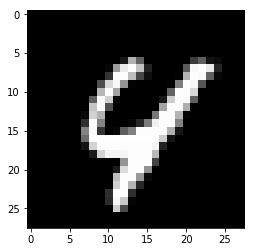

In [17]:
plt.imshow(np.squeeze(x_test[i]),cmap='gray')
plt.show()

In [18]:
# model misclassifies adversarial example as a 2
Activation('softmax')(model(np.expand_dims(adv_x_test[i],axis=0)))

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        2.3731004e-14]], dtype=float32)>

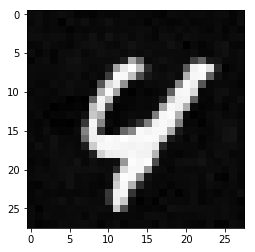

In [19]:
plt.imshow(np.squeeze(adv_x_test[i]),cmap='gray')
plt.show()